In [1]:
from gensim.models import KeyedVectors

fr_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.fr.vec")
en_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.en.vec")

from gensim.models import KeyedVectors
import numpy as np

ar_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.ar.vec", limit=50000)

# Pad the vectors with zeros to match the desired dimensionality (300 in this case)
vector_size = 300
new_vectors = np.zeros((len(ar_embeddings.key_to_index), vector_size))
for word, idx in ar_embeddings.key_to_index.items():
    if len(ar_embeddings.get_vector(word)) == vector_size:
        new_vectors[idx] = ar_embeddings.get_vector(word)
    else:
        print(f"Skipping word '{word}' with vector size {len(ar_embeddings.get_vector(word))}")
ar_embeddings.vectors = new_vectors
ar_embeddings.vector_size = vector_size

import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD


def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    return question_embeddings



## SVM rbf 

In [2]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM with RBF kernel on the training set
svm = SVC(kernel='rbf')
history = svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.8422
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      4961
    positive       0.85      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



[[4185  776]
 [ 802 4237]]


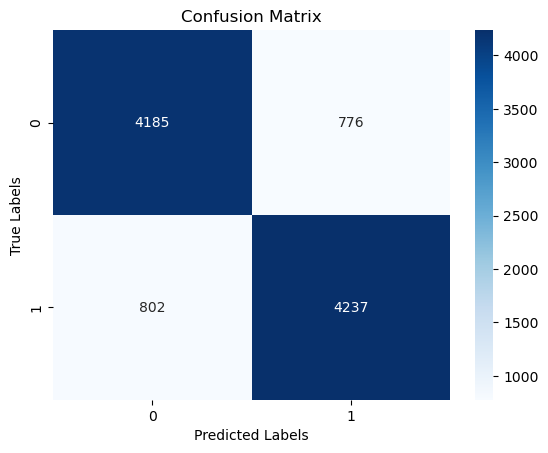

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## Arabic

In [4]:
df = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df.shape)
df = df.head(500)
print(df.shape)
df.head()

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(500, 7)
Accuracy: 0.53125
              precision    recall  f1-score   support

    negative       0.86      0.07      0.14        80
    positive       0.52      0.99      0.68        80

    accuracy                           0.53       160
   macro avg       0.69      0.53      0.41       160
weighted avg       0.69      0.53      0.41       160



[[ 6 74]
 [ 1 79]]


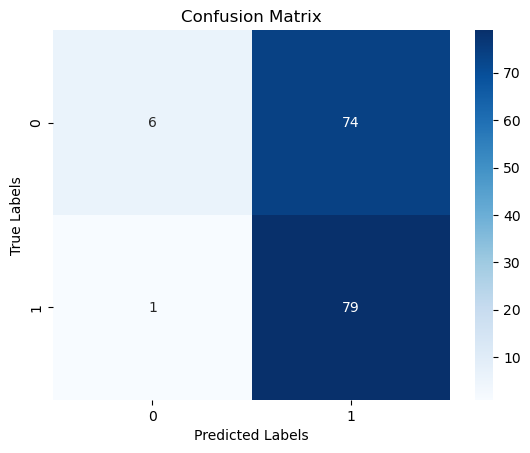

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## French

In [6]:
import pandas as pd

df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

print(df.shape)
df = df.head(500)
print(df.shape)
df.head()
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

(1526724, 2)
(500, 2)


C:\Users\ALI\AppData\Local\Temp\ipykernel_13128\1766107580.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


Accuracy: 0.538
              precision    recall  f1-score   support

           0       0.60      0.22      0.33       250
           1       0.52      0.85      0.65       250

    accuracy                           0.54       500
   macro avg       0.56      0.54      0.49       500
weighted avg       0.56      0.54      0.49       500



[[ 56 194]
 [ 37 213]]


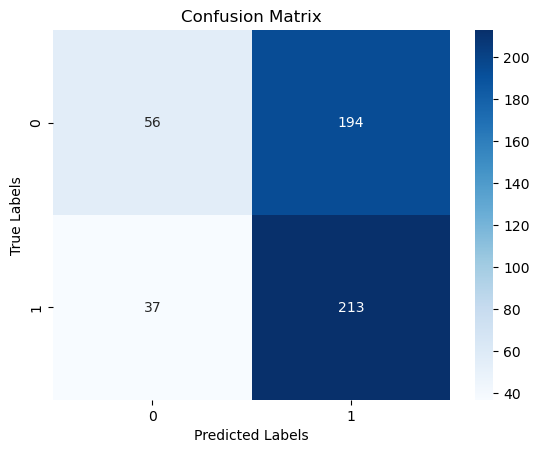

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## Stand SVM rbf

In [9]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features using a scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM with RBF kernel on the standardized training set
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the standardized testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.8581
              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      4961
    positive       0.86      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



[[4234  727]
 [ 692 4347]]


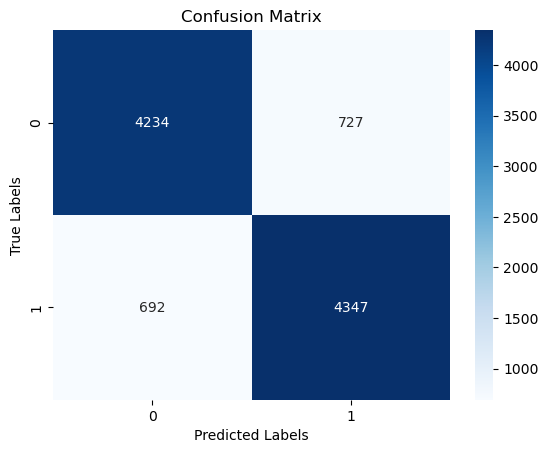

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## Arabic

In [11]:
df = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df.shape)
df = df.head(500)
print(df.shape)
df.head()

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(500, 7)
Accuracy: 0.49375
              precision    recall  f1-score   support

    negative       0.50      0.99      0.66        80
    positive       0.00      0.00      0.00        80

    accuracy                           0.49       160
   macro avg       0.25      0.49      0.33       160
weighted avg       0.25      0.49      0.33       160



[[79  1]
 [80  0]]


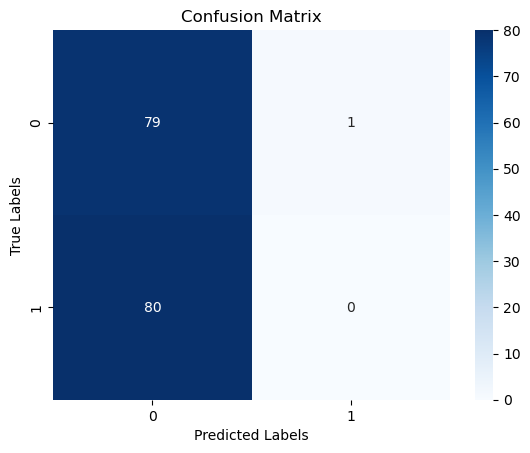

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## French

In [13]:
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

C:\Users\ALI\AppData\Local\Temp\ipykernel_13128\1687517948.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       250
           1       0.00      0.00      0.00       250

    accuracy                           0.50       500
   macro avg       0.25      0.50      0.33       500
weighted avg       0.25      0.50      0.33       500



C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[250   0]
 [250   0]]


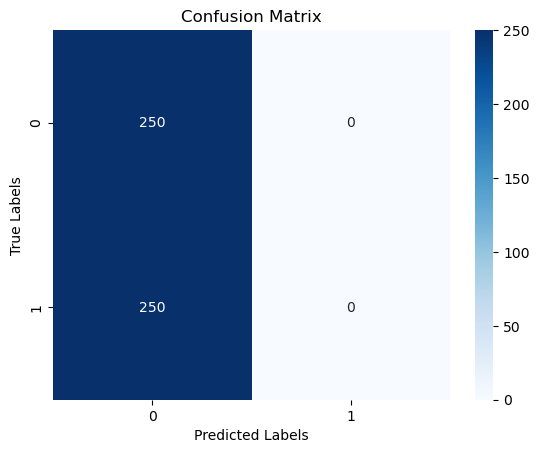

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Stand SVM Linear

In [15]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features using a scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM with linear kernel on the standardized training set
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the standardized testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.8442
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      4961
    positive       0.85      0.84      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



[[4187  774]
 [ 784 4255]]


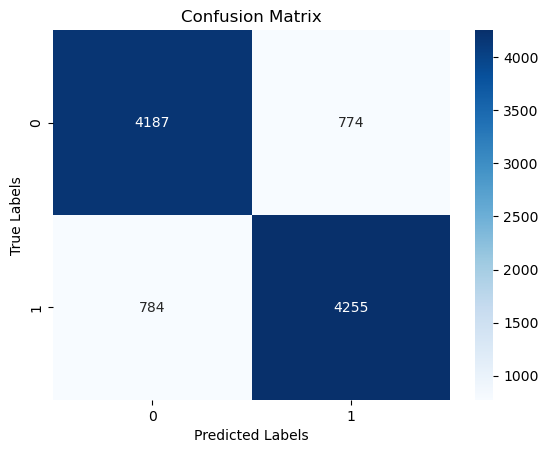

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## Arabic

In [17]:
df = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df.shape)
df = df.head(500)
print(df.shape)
df.head()

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings
X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(500, 7)
Accuracy: 0.5
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        80
    positive       0.50      1.00      0.67        80

    accuracy                           0.50       160
   macro avg       0.25      0.50      0.33       160
weighted avg       0.25      0.50      0.33       160



C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ALI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0 80]
 [ 0 80]]


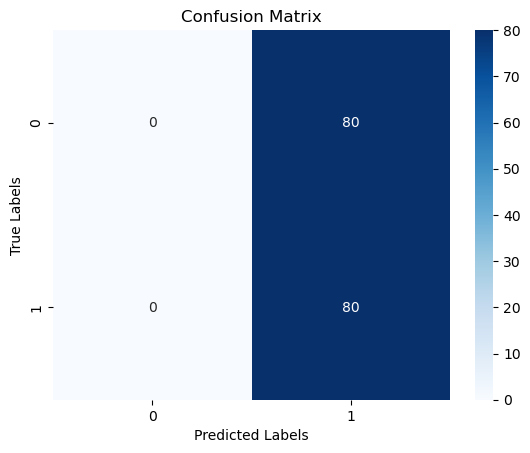

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## French

In [19]:
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

C:\Users\ALI\AppData\Local\Temp\ipykernel_13128\1687517948.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


Accuracy: 0.498
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.50      1.00      0.66       250

    accuracy                           0.50       500
   macro avg       0.25      0.50      0.33       500
weighted avg       0.25      0.50      0.33       500



[[  0 250]
 [  1 249]]


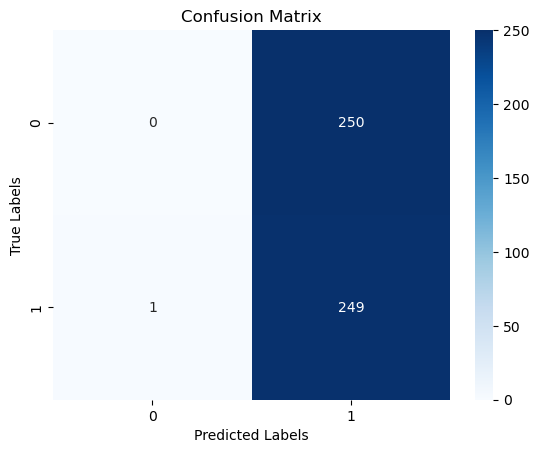

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()